In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import ConcatDataset, Dataset, DataLoader, RandomSampler
from torch import Tensor, optim
torch.manual_seed(0)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
import numpy as np
root_dir = ''
!pip install tsai
from tsai.all import *

# **Parameters**
Dataset generation parameters,

Model trining hyper-parameters,

and General workflow parameters

### SM generation

This section defines the par|ameters used to generate the data set.

The different conditions suppose to help imitating a human movement.

In [71]:

train_data_with_stops = 0.001       # chances for a profile to include stop in the movement
overlapping_range = (0.25, 0.75)    # if not include stop, this is the overlapping range
with_stops_range = (1., 1.15)       # if does include stops, this is the stop length
t_first_range = 1.                  # last time (in sec.) for the first sub movement to start
duration_min = 0.167                # minimal duration
duration_max = 1.                   # maximal duration
amp_min = 0.1                       # minimal amplitude - not including neglect movements in the data
amp_max = 1                         # maximal amplitude - reflects the maximal displacement for positive direction
amp_duration_ratio = 2              # limits the amplitude peaks accordingly to the movements duration
amount_per_seconds = {"amount": 4,  # maximal sub movements per seconds limitation
                      "seconds": 1.8}

s_rate = 100                        # sample rate
len_synthesize = 5                  # length of the first synthesized vector in seconds
real_len = 4                        # length of the actual vector after trimming the end (allowing trimmed SMs)
max_M = 7                           # maximal amount of submovements
dim = 1                             # The spatial dimension

# NOTICE: the shape of the
# parameters matrix for every velocity
# vector is always: (max_M, 2 +dim)

filter_size_mean = 4                # the higher the value, the subtler filter

### Model Training

This section defines the default values for the hyper-parameters. Most of them are not in use explicitly, but just as a default values for the different pytorch models I have implemented.

In [72]:
# Regularizations strenghts
sgl_lambda = 0.
l2_reg = 0.0001

# learning rate
lr = 0.

# LSTM default settings
hidden_size = 64
num_layers = 5

# relevant for all models
input_size = real_len * s_rate       # sequence length
output_size = max_M * (2 + dim)      # parameters matrix

batch_size = 64
epochs = 15

### General
Some general global variables. The important one is `ts` that holds the global time stamps vector in use in this notebook.

In [73]:
models = ["CNN", "LSTM", "LSTM bi", "BOF"]

# losses options are described in the Loss section
losses = ["V", "P", "V+", "P+", "BOF"]

# A generic time stamps vector in the size of sequence length
ts = torch.linspace(0, real_len, s_rate * real_len).to('cuda')

# **Utilities**
*Signal utilities:* Filtering, Velocity Profiles Reconstruction, Minimum-Jerk curves calculation, and Plot helper.

*pytorch utilities:* Flattening layer, Dimensions-print layer, Clipping layer, and Dataloaders.

## **Signal utilities**

### Filter Signal
Filtering velocity profiles vectors.
The smoothed profile should reflect a more natural human movement.

The function handles either batch filtering or a single sample filtering.

**Input shape: either** `(N, d, len)` **or** `(d, len)`, where `N` is batch size, `d` is the spatial dimension and `len` in sequence length.  

In [74]:
from scipy.signal import filtfilt, butter

def filter_signal(vel, time=ts):
    filter_size = torch.rand(1) + filter_size_mean - 0.5    # filter size is ~filter_size_mean
    dt = torch.median(torch.diff(time))
    b, a = butter(2, filter_size / ((1 / dt) / 2))

    # Convert numpy arrays to PyTorch tensors
    b = torch.tensor(b, dtype=torch.float32)
    a = torch.tensor(a, dtype=torch.float32)

    filtered_signal = filtfilt(b, a, vel.cpu().numpy())
    
    return torch.from_numpy(filtered_signal.copy())

### Batch Reconstruction
Given a batch of sub movements parameters, reconstruct the velocity profiles. Note that the batch is the output from the model.

__Input shape__: `(N, max_M * (d+2))`, where `N` is batch size

In [75]:
def batch_reconstruct_prof(batch):
    batch = batch.view(batch.shape[0], max_M, dim + 2)
    
    T = batch[:, :, 0]
    D = batch[:, :, 1]
    A = batch[:, :, 2:]
    min_jerk_profiles = minimum_jerk_velocity(T.unsqueeze(-1), D.unsqueeze(-1), A, ts, True)

    return torch.sum(min_jerk_profiles, dim=1)

### Minimum Jerk Curve
Given a Minimum Jerk parameters (Time, Duration, Amplitudes), return a polynomial curve described here:

Flash and Hogan (1985):
https://www.jneurosci.org/content/5/7/1688.short

**Input shapes:** 

*if* `batch=True`:

***start_t*** & ***duration:*** `(N, max_M)`, where `N` is batch size.
***amplitudes:*** `(N, max_M, d)`, where `d` is the spatial dimension.

*if* `batch=False`:

***start_t*** & ***duration:*** `(max_M,)`
***amplitudes:*** `(max_M, d)`, where `d` is the spatial dimension.

*The firsrt cell is old, and should be carefully reased.*

In [76]:
# # OLD VERSION - need to be erased safely
# def _minimum_jerk_velocity_1D(start_t, duration, amplitudes, t = ts):

#     d = len(amplitudes)
#     displacements = []
    
#     # normalise time to t0 and movement duration, take only the time of the movement
#     normalized_time = (t - start_t) / duration
#     logical_movement = (normalized_time >= 0) & (normalized_time <= 1)

#     # normalize displacements
#     for amp in amplitudes:
#         displacements.append(amp / duration)

#     displacements = Tensor(displacements).reshape(d, 1)

#     # initializes velocities
#     vel = torch.zeros((t.shape[0], d))
    
#     # calculate velocities
#     def min_jerk_polynomial(base_val):
#         # the polynomial function from Flash and Hogan (1985)
#         return base_val * (-60*normalized_time[logical_movement]**3 + 30*normalized_time[logical_movement]**4 + 30*normalized_time[logical_movement]**2)

#     vel[logical_movement, :] = min_jerk_polynomial(displacements).T
    
#     return vel.permute(1,0)

In [77]:
def minimum_jerk_velocity(start_t, duration, amplitudes, t = ts, batch=True, eps=1e-12):
    
    duration[duration == 0] = eps    # preventing division-by-zero

    max_M, d = amplitudes.shape[-2:]
    
    # normalise time to t0 and movement duration, take only the time of the movement
    normalized_time = (t - start_t) / duration
    logical_movement = ((normalized_time >= 0) & (normalized_time <= 1)).long()

    displacements = (amplitudes / duration)
    displacements = displacements[:, :, :, None] if batch else displacements[:, :, None]
    
    # the polynomial function from Flash and Hogan (1985)
    norm_time = normalized_time * logical_movement
    region = norm_time[:, :, None, :] if batch else norm_time[:, None, :]
    min_jerk_profiles = displacements * (-60*region**3 + 30*region**4 + 30*region**2)

    return min_jerk_profiles

### **Sample Plot**
Plot velocity profile with sub movements decomposition

atm ONLY support 1-d movement

In [78]:
from matplotlib import pyplot as plt

def plot_sample(param, M=max_M, ts=ts, real_vel=None, axs=None, show=False, legend=True):
    
    param = param.detach().view(max_M,2+dim)
    pred_M = calculate_M(param, batch=False)
    
    if not axs:
        fig, axs = plt.subplots(1, 1)

    # plot the sub movements and the reconstructed profile
    vel = torch.zeros((ts.shape[0],1))
    for i in range(M):
        T, D, A = param[i, 0], param[i, 1], param[i, 2:]
        prof = _minimum_jerk_velocity_1D(T, D, A, ts)
        vel += prof
        axs.plot(ts, prof, linestyle=':', linewidth=0.7)
        
    axs.plot(ts.detach(), vel.view(-1), 'gray', linewidth=0.8, label="Reconstructed vel.")
    axs.set_xlabel("pred M: {}".format(pred_M))
    axs.set_ylim([-(amp_duration_ratio*2), amp_duration_ratio*2])

    # plot the real velocity profile if given
    if real_vel is not None:
        axs.plot(ts.detach(), real_vel.detach().view(-1), 'red', linewidth=0.9, label="Real vel.")
    if legend:
        axs.legend()
    if show:
        plt.show()

## **Pytorch utilities**

### Flatten module, to use in nn.Sequencial

In [79]:
class FlattenBatch(nn.Module):
    def __init__(self):
        super(FlattenBatch, self).__init__()
    def forward(self, x):
        return x.flatten(1)

### Printer module, to use in nn.Sequencial

In [80]:
class PrintDim(nn.Module):
    def __init__(self, to_print=True, print_data=False):
        super(PrintDim, self).__init__()
        self.to_print = to_print
        self.print_data = print_data
    def forward(self, x):
        if self.print_data:
            print("input: ", x)
        if self.to_print:
            print("dimensions: ", x.shape)
        return x

### Clipping Layer
To clip infeasible values from the model's outputs.

**input shape:** `(N, max_M * (d+2))` where `N` is the batch size

**output shape:**  same as input 

In [81]:
class ClipOutput(nn.Module):
    def __init__(self, min_duration, min_amp):
        super(ClipOutput, self).__init__()
        self.min_D = min_duration
        self.min_amp = min_amp

    def forward(self, x):        
        batch_size = x.size(0)
        x = x.view(batch_size, -1, dim + 2)
        
        time_mask = (x[:, :, 0] < 0)
        duration_mask = (x[:, :, 1] < self.min_D)
        amp_mask = (torch.abs(x[:, :, 2:]) < self.min_amp).any(dim=2)
        mask = (time_mask | duration_mask | amp_mask).unsqueeze(-1)
        x = x * (~mask)
        
        return x.view(batch_size, -1)

### **Errors definitions**

In [82]:
class AmountPerSecondsViolation(Exception):
    def __init__(self, message="Violation of limitation: Amount of submovements per second. This movement was stashed"):
        self.message = message
        super().__init__(self.message)

### Dataloader
Given path to data objects, list of M (amount of SMs) and percentages of training set, return train dataloader and validation dataloader instaces, shuffled and with the appropriate batch size.

Insures that the data will be in the shape:

* `velocities.shape = ([N * M, real_len * s_rate])`
* `parameters.shape = ([N * M, max_M * (2+d)])`
* `amounts.shape = ([N * M])` 

Where: `M` is the length of the list of M argument, `max_M` is maximal SMs, `d` is the spatial dimension, `s_rate` is the sample rate, and `real_len` is the sequence's length in seconds. All are defined in the parameters section.

In [83]:
class SubMovDataloader(Dataset):
    def __init__(self, velocities, amounts, parameters):
        if len(velocities.shape) == 2:
            velocities = velocities[:,None,:]
        
        self.velocities = velocities
        self.amounts = amounts
        self.parameters = parameters.nan_to_num()

    def __len__(self):
        return len(self.amounts)

    def __getitem__(self, idx):
        vel = self.velocities[idx]
        M = self.amounts[idx]
        param = self.parameters[idx]
        return vel, M, param

In [84]:
def load_np_data(vel_path, M_path, param_path, batch_size, M_lst: list = [], train: float = 0.8):
    velocities = Tensor(np.load(vel_path)).permute(0,2,1)
    amounts = Tensor(np.load(M_path))
    parameters = torch.flatten(Tensor(np.load(param_path)), start_dim=1)
    
    return load_data(velocities, amounts, parameters, batch_size, M_lst, train)

In [85]:
def load_torch_data(vel_path, M_path, param_path, batch_size, M_lst: list = [], train: float = 0.8):
    velocities = torch.load(vel_path)
    amounts = torch.load(M_path)
    parameters = torch.load(param_path)
    
    return load_data(velocities, amounts, parameters, batch_size, M_lst, train)

In [86]:
def load_data(velocities, amounts, parameters, batch_size, M_lst: list = [], train: float = 0.8):

    N = len(amounts) // (max_M-1)   # How many samples per each value of M
    mask = torch.full((len(amounts),), True, dtype=bool)   # will mask the output to the desired M values

    # take only desired values of M
    if M_lst:
        mask[:] = False
        for M in M_lst:
            if M < 2 or M > max_M:
                raise ValueError("M_lst must contains values only in the range [2, max_M]")
            mask[(M-2)*N:(M-1)*N] = True
    
    # convert to Pytorch's Dataloader instance and split to train and validation
    dataloader = SubMovDataloader(velocities[mask], amounts[mask], parameters[mask])
    print("data size :", amounts[mask].shape)
    
    train_set, val_set = torch.utils.data.random_split(dataloader, [train, 1 - train])
    
    train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_set, batch_size=1024, shuffle=True)

    return train_dataloader, val_dataloader

In [87]:
def get_data_loader(data_type="Big", batch_size=64, M_lst=[], train_percentages=0.8):
    # instansiate a dataloader with proper batch size
    
    data_path = root_dir + "Dataset/%s" % data_type + "/{}.pt"
    vel_path, M_path, param_path = data_path.format('vel'), data_path.format('amounts'), data_path.format('param')
    return load_torch_data(vel_path, M_path, param_path, batch_size, M_lst=M_lst, train=train_percentages)

# **Dataset Generation**
The shape of a dataset contains N samples for each M - amounts of SMs (All are torch.Tensor objects):
* `velocities.shape = ([N * M-1, real_len * s_rate])`
* `parameters.shape = ([N * M-1, M * (2+d)])`
* `amounts.shape = ([N * M-1])` 

Where: `M` is `max_M`, `d` is the spatial dimension, `s_rate` is the sample rate, and `real_len` is the sequence's length in seconds. All are defined in the parameters section.

*__The data was tested so far is only 1 dimensional. The code should work with multidimensional data, but this scenario hasn't been tested yet.__*

*The 1-d data realizability was tested with the optimization algorithm, as can be shown in the figure:*
![alt text](Opt-Algorithm_on_Dataset.png)
*The real profile is covered almost entirely by the reconstructed profile.*
*It also shows that the algorithm take very long time to compute...*

### Sub movement generation
The process of generating the sub movements parameters while maintaining the following restrictions:


*   Fully-included SM in another one is not allowed (`T_i + D_i > T_i-1 + D_i-1`)
*   At most 2 SMs overlapping at any time
*   Prevent spikes in amplitudes (`amp_duration_ratio` parameter), as well as very low amplitudes (`amp_min` parameter)
*   Most of the SMs are overlapping (`train_data_with_stops` is the percentages, `overlapping_range` is the area of overlap)
*   Keep amplitudes in reasonable values, by limit the displacements results from the movements to be in the range of [-1, 1], represents a normalized work board





First sub movement

In [88]:
def first_random_sub_movement(d: int = 1):
    t_start = np.random.uniform(0., t_first_range)
    duration = np.random.uniform(duration_min, duration_max)
    amp = np.random.uniform(amp_min, min(amp_max, duration / amp_duration_ratio), size=(d,)) * \
          np.random.choice([-1, 1], size=(d,))  # directions of the movements
    return Tensor(np.c_[t_start, duration, amp])

All the rest

In [89]:
def random_sub_movement(prev_T: float, prev_D: float, pos: np.ndarray, prev_prev_dt : float = 0.,
                        amount_per_sec_prev_T: float = -np.inf, d: int = 1) -> np.ndarray:

    # randomly decide whether this SM is overlapping or not
    with_stops = np.random.randint(0,int(1/train_data_with_stops)) == 1
    a, b = with_stops_range if with_stops else overlapping_range

    # choose start time
    s = max(prev_T, prev_prev_dt)       # prevent more than 2 overlapping submovements at any time
    prev_dt = prev_T + prev_D - s
    t_start = np.random.uniform(s + a*prev_dt, s + b*prev_dt)

    # choose duration
    min_D = max(duration_min, prev_T + prev_D - t_start)        # prevent fully-included submovements in another one
    duration = np.random.uniform(min_D, duration_max)
    if t_start + duration - amount_per_sec_prev_T < amount_per_seconds["seconds"]:
        return random_sub_movement(prev_T, prev_D, pos, prev_prev_dt, amount_per_sec_prev_T, d)

    # choose amplitudes
    # define the possible intervals for the amplitude in according to the current position
    intervals = np.array([[((-amp_max-p)* duration, -amp_min),                  # spatial restriction to sum
                           (amp_min, (amp_max-p)* duration)] for p in pos])     # the displacement to maximum of |1|
    # Choose a direction
    directions = np.random.choice([0, 1], size=intervals.shape[0])
    # Generate random numbers based on the chosen intervals
    amp = np.zeros(d)
    for i in range(d):
        rng = intervals[i][directions[i]]
        amp[i] = np.random.uniform(rng[0], rng[1])
        if np.abs(amp[i]) / duration > amp_duration_ratio:              # limit the ration between amplitude
            amp[i] = np.sign(amp[i]) * amp_duration_ratio    # and duration to prevent high spikes

    return Tensor(np.c_[t_start, duration, amp])

### Sample generation
A single full-sample generation contains tuple of Tensors.

Shape:
`[vel, M, param]` Where :

*   `vel.shape = (400,1)` represents 1-d velocity vector of 4 seconds (100Hz)
*   `M.shape = (1,)` is the amount of sub movements created this velocity profile
*   `param.shape = (max_M, 3)`, the parameters of the sub movements. If `M < max_M`, than `param[M:] = NaN`

random parameters generation, given `m` amount of sub movements and `d` dimension

In [90]:
def random_sub_movements_parameters(m: int, d: int = 1):
    param = torch.zeros((m,2+d))
    pos = torch.zeros((d,))

    # first sub movement
    param[0, :] = first_random_sub_movement(d = d)

    prev_prev_dt = 0.
    amount_per_sec_prev_T = -torch.inf

    # build m-1 more sub movements
    try:
        for i in range(1, m):
            last_displacement = param[i-1, 2:] / param[i-1, 1]      # displacement = A / D
            pos += last_displacement                    # update the positions in according to the last displacement
            param[i, :] = random_sub_movement(prev_T = param[i-1, 0], prev_D = param[i-1, 1], pos = pos,
                                              prev_prev_dt = prev_prev_dt, amount_per_sec_prev_T = amount_per_sec_prev_T, d = d)
            prev_prev_dt = param[i - 1, 0] + param[i - 1, 1]
            if i >= amount_per_seconds["amount"]-2:
                amount_per_sec_prev_T = param[i-2, 0]
    except RecursionError:
        raise AmountPerSecondsViolation

    return param

sample generation, summerizes the sub movement into a velocity profile.
Parameters matrix is always of size `max_M x d`, and if `M < max_M`, than there will be `NaN` values in the matrix

In [91]:
def build_sample(M: int, d: int = 1) -> tuple:
    vel = torch.zeros((ts.shape[0], d))
    param = random_sub_movements_parameters(M, d)
    for i in range(M):
        T, D, A = param[i, 0], param[i, 1], param[i, 2:]
        prof = _minimum_jerk_velocity_1D(T, D, A)
        vel += prof
        
    full_matrix = torch.empty((max_M, d+2))
    full_matrix[:M] = param
    full_matrix[M:] = torch.nan
        
    return vel[:real_len * s_rate, :], full_matrix

## **Generate The Dataset**

In [92]:
import time

def generate_db(N, dim=1, path="{}", plot=False):
    print("Generating batch")
    
    velocities = torch.empty(size=(dim,ts.shape[0]))
    parameters = torch.empty(size=(1,max_M*(dim+2)))
    amounts = []

    fails, times = 0, []

    # amount varies between 2 and max_M submovements
    for m in range(2, max_M+1):
        print("start M=", m)
        i = 0

        # for each amount, create N samples
        while i < N:
            t = time.time()
            try:
                vel, param = build_sample(M=m, d=dim)
                velocities = torch.row_stack((velocities,vel.permute(1, 0)))
                parameters = torch.row_stack((parameters,param.view(1,-1)))
                amounts.append(m)
                i+=1
                
                if plot:
                    plot_sample(param.view(max_M,dim+2), real_vel=vel)

            except AmountPerSecondsViolation:
                fails += 1
            finally:
                if i % 2000 == 1999:
                    print("--------Progress:  ", ((m-1)*i) / ((max_M-1)*N))
                times.append(time.time() - t)

    print("--------Failures %: {}.     Average time: {}".format(fails / len(times), torch.mean(Tensor(times))))
    print("--------Total time: ", torch.sum(Tensor(times)))
    
    torch.save(velocities[1:], path.format('vel.pt'))
    torch.save(parameters[1:], path.format('param.pt'))
    torch.save(Tensor(amounts), path.format('amounts.pt'))

    print("Done\n\n")

# **Custom Loss Functions Definition**
several loss function are defined here:
1. `"V"` - Velocity cost loss function
2. `"P"` - MSE on the parameters matrix

additionally punishments are for:
* Wrong prediction on M (calculation described in the helper function)
* Unfeasible values for time, duration or amplitude

*For the addition of punishment, concatenate `"+"` to the loss string*

**NOTICE:** All losses except "BOF", recieve:
`real_vel, real_P, real_M, pred_vel, pred_P`

### Calculate M of a given parameters matrix

Equivalent operation as ClipOutput layer does, except here you can pass parameters vector at any shape and for a single sample also.

**input shape:** 

*if* `batch-True`: either `(N, max_m*(d+2))` or `(N, max_M, d+2)`

*if* `batch-False`: either `(max_m*(d+2),)` or `(max_M, d+2)`

In [120]:
def calculate_M(P, batch=True, amp_tol=0.005):
    # return how many SM there are in a given Parameters matrix
    # maintain the input dimension, compatible with either batch or single sample
    # The ooperation is as follow:
    # - zeros all rows that satisfies 1 or more conditions:
    #      1) amplitudes < amp_tol
    #      2) duration < min_duration
    #      3) start < 0.
    # - return number of rows that are not zeros
    
    if not batch:
        if len(P.shape) == 1:
            P = P.view(max_M,dim+2)
        P[P[:,0] <= 0., :] = 0.                         # time
        P[P[:,1] < duration_min, :] = 0.                # duration
        P[torch.abs(P[:,2:])[:,0] <= amp_tol, :] = 0.   # amp
        P = torch.sum(P, dim=1)
        return torch.sum(P != 0)
    
    else:
        N = P.shape[0]
        if len(P.shape) == 3:
            P = P.view(P.shape[0],max_M * (dim+2))        
        cliper = ClipOutput(duration_min, amp_tol)
        P = cliper(P).view(N, -1, dim+2)
        
        # Count the number of non-zero rows for each sample in the batch
        non_zero_counts = torch.count_nonzero(P, dim=1)
        return non_zero_counts[:,0]

### Velocity Cost Function
Here defined the basic cost function of the velocity profile, as described here:

Friedman, & Finkbeiner, 2010:

https://www.researchgate.net/profile/Jason-Friedman-3/publication/228566929_Temporal_dynamics_of_masked_congruence_priming_evidence_from_reaching_trajectories/links/09e4150e8f67308733000000/Temporal-dynamics-of-masked-congruence-priming-evidence-from-reaching-trajectories.pdf

In [35]:
def tan_vel(vel, batch=True):
    # calculate the tangential velocity of a given velocity tensor of shape (batch, d, N) or (d, N) if batch=False
    # for d = 1, the tengential velocity it's just the absolute value
    
    dim_to_sum = 1 if batch else 0
    
    sqr_vel = vel**2
    sum_sqr_vel = torch.sum(sqr_vel, dim=dim_to_sum)
    tan_vel = torch.sqrt(sum_sqr_vel + 1e-12)    # add a small value to prevent NaN derivative on 0

    return tan_vel

In [36]:
def velocity_cost(real, pred):
    # calculate the loss of the velocity profile, including a loss term 
    # to minimze the possibilities for overlapping curves that are on
    # opposite directions
    
    sqr_err = (real-pred)**2
    sum_sqr_err = torch.sum(sqr_err,dim=1)
    
    tan_err = (tan_vel(real) - tan_vel(pred))**2
    
    total_err = sum_sqr_err + tan_err

    return torch.mean(torch.sum(total_err, dim=1))

### Additional Punishments
punish M with CrossEntropy (treat as a classification problem), and infeasible values

In [37]:
def punishment(real_M, pred_P):
        
    # punish every entry of T < 0
    time_punish = torch.sum(pred_P[: :, 0] < 0.)  

    # punish every entry of D < duration_min
    duration_punish = torch.sum(pred_P[: :, 1] < duration_min)   

    # add a loss term on M value - a CrossEntropyLoss
    real_M_hot_vec = nn.functional.one_hot(real_M.long(), num_classes=max_M+1).float()
    pred_M_hot_vec = nn.functional.one_hot(calculate_M(pred_P).long(), num_classes=max_M+1).float()
    M_punish = nn.CrossEntropyLoss()(real_M_hot_vec, pred_M_hot_vec)

    # scaling the punishments accordinly to the dimensions
    T_D_punishes = (time_punish + duration_punish + M_punish) / (pred_P.shape[0] * max_M)
    M_punish = M_punish / max_M
    
    return T_D_punishes + M_punish

### SGL(Sparse Group Lasso) definition
SGL as described here:

https://arxiv.org/abs/1607.00485

In [38]:
def SGL(W, lambda1, lambda2):
    # Calculate L1 regularization on individual weights
    l1_reg = lambda1 * torch.norm(W, p=1)
    
    # Calculate L2 regularization on groups of weights
    group_reg = 0
    for row in W:
        group_reg += lambda2 * torch.norm(row, p=2)
    
    return l1_reg + group_reg

### "P" loss definition

In [39]:
class ParametersLoss(nn.Module):
    def __init__(self, with_punish=False):
        super(ParametersLoss, self).__init__()
        self.with_punish = with_punish
        
    def forward(self, real_P, pred_P, real_M): 

        # simple MSE on the parameters matrices
        mse_loss = nn.MSELoss()(real_P, pred_P) 
        
        # add punish
        if self.with_punish:
            
            # real & pred are matrix of: (batch_size, max_M * dim+2), reshape to: (batch, M, d+2)
            pred_P = pred_P.view(-1, max_M, dim+2)   
            
            punish = punishment(real_M, pred_P)
            return mse_loss + 0.1 * punish
         
        return mse_loss

### "V" loss definition

In [40]:
class VelLoss(nn.Module):
    def __init__(self, with_punish=False):
        super(VelLoss, self).__init__()
        self.with_punish = with_punish
        
    def forward(self, real_vel, real_P, real_M, pred_vel, pred_P):
        
        # simple MSE on the velocity profiles
        mse_loss = velocity_cost(real_vel, pred_vel) 
        
        # add punish
        if self.with_punish:
            
            # real_P & pred_P are matrix of: (batch_size, max_M * dim+2), reshape to: (batch, M, d+2)
            pred_P = pred_P.view(-1, max_M, dim+2)
        
            punish = punishment(real_M, pred_P)
            return mse_loss + punish
         
        return mse_loss

### loss getter (generate pytorch criterion instance)

Possible values are: `"V"`, `"V+"`, `"P"`, `"P+"`, `"BOF"`

In [41]:
def get_loss_function(loss_type="P"):
    if loss_type not in losses:
        raise ValueError('{} is not a valid loss_type. \
                        loss_type must be one of: \
                        "V" / "V+" for velocity reconstruction error, \
                        "P" / "P+" for parameters MSE loss, \
                        or "BOF" for BoF MSE'.format(loss_type))  
    
    # reconstruction error
    if loss_type == "V":
        V_Loss = VelLoss()
        loss = lambda real_vel, real_P, real_M, pred_vel, pred_P : V_Loss(real_vel, real_P, real_M, pred_vel, pred_P)
    
    # reconstruction error with punish for infeasible values of parameters
    elif loss_type == "V+":
        V_plus_Loss = VelLoss(with_punish=True)
        loss = lambda real_vel, real_P, real_M, pred_vel, pred_P : V_plus_Loss(real_vel, real_P, real_M, pred_vel, pred_P)
    
    # parameters error
    elif loss_type == "P":
        P_Loss = ParametersLoss()
        loss = lambda real_vel, real_P, real_M, pred_vel, pred_P : P_Loss(real_P, pred_P, real_M)
    
    # parameters error with punish for infeasible values
    elif loss_type == "P+":
        P_plus_Loss = ParametersLoss(with_punish=True)
        loss = lambda real_vel, real_P, real_M, pred_vel, pred_P : P_plus_Loss(real_P, pred_P, real_M)
    
    # BoF error - simply mse loss for costume use in the BOF-training loop
    elif loss_type == "BOF":
        loss = nn.MSELoss()
    
    return loss

# **My-Models section:**
In this section there are several models that I have implemented:

1) CNN - a convolutional neural network
2) LSTM - a long-short term memory (RNN)
3) BoF - a bag of function, model that meant to decompose signals

The Bof is potentailly be high-relevant for our task. I haven't manage to train it well; maybe because I only used my implementation of LSTM model as encoders, and tsai's models might perform better.

*__Recommendation: The models here are not state-of-the art models, and you should only use the "tsai's Models" section.__*

## **models**

In [93]:
def count_parameters(model):
    count = 0
    for p in model.parameters():
        count += len(p)
    return count

### CNN

The model architecture:


*   **3 Convolutional layers** (Conv1d -> BN1d -> LeakuReLU)
*   **MLP** containing 3 Fully Connected layers
*   **W**: Fully Connected layer for group sparse the results

In [94]:
class SubMovCNN(nn.Module):
    def __init__(self, feat=16, print=False):
        super(SubMovCNN, self).__init__()
        self.seq = nn.Sequential(
            # current size: 1 x 1 x 400
            PrintDim(print),
            nn.Conv1d(in_channels=1, out_channels=feat, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(feat*200),
            nn.ReLU(),

            # current size: 1 x feat x 200
            PrintDim(print),
            nn.Conv1d(in_channels=feat, out_channels=2*feat, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(2*feat*200),
            nn.ReLU(),

            # current size: 1 x 2*feat x 100
            PrintDim(print),
            nn.Conv1d(in_channels=2*feat, out_channels=4 * feat, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(2*feat*200),
            nn.ReLU(),

            # current size: 1 x 4*feat x 50
            PrintDim(print),
            FlattenBatch(),
            nn.Linear(4 * feat * 50, 720),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(720, 100),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(100, 7 * 3),

            PrintDim(print),
        )

        # the group-sparse term
        self.W = nn.Linear(7*3, 7*3, bias=False)

    def forward(self, x):
        return self.W(self.seq(x))

### LSTM
Optional: bidirectional.

In [95]:
class SubMovLSTM(nn.Module):
    def __init__(self, input_size=dim*input_size, hidden_size=hidden_size,
                      num_layers=num_layers, output_size=output_size, dropout=0.2, bidirectional=True):
        super(SubMovLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.directions = 2 if bidirectional else 1
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout,
                            batch_first=True, bidirectional=bidirectional)
        self.bn = nn.BatchNorm1d(2 * hidden_size)
        self.mlp = nn.Sequential(
            nn.Linear(2 * hidden_size, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, output_size),
        )

    def forward(self, x):
        
        # initializes of hidden states
        h0 = torch.ones(self.directions*self.num_layers, x.shape[0], self.hidden_size)
        c0 = torch.ones(self.directions*self.num_layers, x.shape[0], self.hidden_size)
                
        # pass through LSTM. notice that output contains only 1-directional pass
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # if bidrectional, should concatenate last pass from both sides, otherwise, just take lase time step
        h_n = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1) if self.directions == 1 else out[:,-1,:]
        
        # batch normalization. perform only for batch bigger than 32 samples
        out = self.bn(h_n) if x.shape[0] >= 32 else h_n
        
        # MLP
        out = self.mlp(out)

        return out

### **BoF (Bag of Functions)**
As described here:

https://www.sciencedirect.com/science/article/pii/S0957417423002889/pdfft?md5=1a853aba33eba3da31f65906a0fd2a88&pid=1-s2.0-S0957417423002889-main.pdf

Functions

Some functions to demonstrate the BoF performance on dummy data

In [96]:
def get_callable_name(item):
    if callable(item):
        if hasattr(item, '__name__'):
            return item.__name__
    return str(item)

####### Trends
def constant(x, y, z, ts=ts):
    return torch.ones(ts.shape) * x

def lin(x, y, z, ts=ts):
    return ts * x

def poly_2(x, y, z, ts=ts):
    return (x * ts**2) + (ts * y)

def poly_3(x, y, z, ts=ts):
    return (x * ts**3) + (y * ts**2) + (z * ts)

def inv_expo_minus(x, y, z, ts=ts):
    return x * (1 - torch.exp(-ts * y))

def inv_expo(x, y, z, ts=ts):
    return x * (1 - torch.exp(ts * y))

def asinh(x, y, z, ts=ts):
    return x * torch.asinh(y * (ts - z))

def exp_trend(x, y, z, ts=ts):
    return x * ((ts + y) ** z)

def log_trend(x, y, z, ts=ts):
    return x * torch.log(ts + y)


####### Seasonality
def sin(x, y, z, ts=ts):
    return x * torch.sin(ts*y + z)

def cosin(x, y, z, ts=ts):
    return x * torch.cos(ts*y + z)

def sinc(x, y, z, ts=ts):
    return x * torch.sinc(ts*y + z)

def rect(x, y, z, ts=ts):
    return x * torch.sign(torch.sin(ts*y + z))


####### Events
def step(x, y, z, ts=ts):
    return x * (y*ts > z).long()

def exp_event(x, y, z, ts=ts):
    return x * torch.exp(-y * (ts - z)**2)

def tanh(x, y, z, ts=ts):
    return x * torch.tanh(y * (ts - z))

def sigm(x, y, z, ts=ts):
    return x * torch.sigmoid(y * (ts - z))

def min_jerk(T, D, A):
    if D == 0:
        D = eps

    # normalise time to t0 and movement duration, take only the time of the movement
    normalized_time = (t - T) / D
    logical_movement = (normalized_time >= 0) & (normalized_time <= 1)

    displacements = Tensor([A/D]).reshape(1,1)

    # initializes velocities
    vel = torch.zeros((t.shape[0], 1))
    
    # calculate velocities
    def min_jerk_polynomial(base_val):
        # the polynomial function from Flash and Hogan (1985)
        return base_val * (-60*normalized_time[logical_movement]**3 + 30*normalized_time[logical_movement]**4 + 30*normalized_time[logical_movement]**2)

    vel[logical_movement, :] = min_jerk_polynomial(displacements).T
    
    return vel.flatten()


min_jerk_bof = [min_jerk]
small_bof = [sin, constant, tanh]
full_bof = [exp_event, tanh, sigm,
       sin, cosin, sinc,
       constant, lin, poly_2, poly_3,
       inv_expo_minus, inv_expo, asinh, exp_trend, log_trend]

Dummy dataset for BoF

In [97]:
class BOFDataloader(Dataset):
    def __init__(self, signals):
        self.signals = signals

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        s = self.signals[idx]
        return s
    
    
def bof_dummy_data_gen(bof, N=10000):
    parameters = torch.rand(size=(N, 3))
    weights = torch.rand(size=(N, len(bof)))
    data = torch.stack([torch.sum(torch.stack([func(*params) * weight for func, weight in zip(bof, weights)]), dim=0)
                          for params, weights in zip(parameters, weights)])
    return data[:,None,:]
    
    
def BOFdummyDataset(bof, N=10000):
    dataloader = BOFDataloader(bof_dummy_data_gen(bof, N))
    
    train_set, val_set = torch.utils.data.random_split(dataloader, [0.8, 0.2])
    
    train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

    return train_dataloader, val_dataloader

Encoder

In [98]:
class EncoderCNN(nn.Module):
    def __init__(self, feat=16, num_layers=3, to_print=False):
        super(EncoderCNN, self).__init__()
        
        c_in = 1 
        modules = []
        
        for i in range(num_layers):
            c_out = (2**i)*feat
            
            modules.append(PrintDim(to_print))
            modules.append(nn.Conv1d(in_channels=c_in, out_channels=c_out,
                                     kernel_size=4, stride=2, padding=1))
            modules.append(nn.BatchNorm1d(c_out))
            modules.append(nn.ReLU())
            
            c_in = c_out
        
        modules.append(FlattenBatch())
        modules.append(PrintDim(to_print))
        self.seq = nn.Sequential(*modules)

    def forward(self, x):
        print(x.shape)
        print((self.seq(x)).shape)
        return self.seq(x)

Heades - MLPs

In [99]:
class HeadMLP(nn.Module):
    def __init__(self, c_in, c_out, to_print=False):
        super(HeadMLP, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(c_in, 100),
            nn.ReLU(),
            # nn.Linear(100, 100),
            # nn.ReLU(),
            nn.Linear(100, c_out),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.seq(x)

BoF Block

In [100]:
class BoFBlock(nn.Module):
    def __init__(self, bof, top_k=1, input_len=input_size, encoder_feat=16, encoder_num_layers=3, to_print=False):
        super(BoFBlock, self).__init__()
        
        # input size: 64 x 1 x 400
        # self.encoder = EncoderCNN(encoder_feat, encoder_num_layers, to_print=to_print)
        
        self.encoder = SubMovLSTM(hidden_size=64, num_layers=3, output_size=3200)
        encoder_out_features = (2**(encoder_num_layers-2))*encoder_feat if encoder_num_layers > 1 else 1
        encoder_out_size = input_len / (2**(encoder_num_layers-1))
        self.heads_in_size = int(encoder_out_features * encoder_out_size // 2)
        
        self.selection_head = HeadMLP(self.heads_in_size, len(bof), to_print=to_print) # outputs weight each function from BoF
        self.parameters_head = HeadMLP(self.heads_in_size, 2+dim, to_print=to_print)   # 2+dim = amount of parameters per SM
        
        self.bof = bof
        self.K = top_k

    def forward(self, x, return_selections=False):
        x = self.encoder(x)
        selection = self.selection_head(x[:,:self.heads_in_size])
        parameters = self.parameters_head(x[:,self.heads_in_size:])
        
        # perform softamx only on the top K weights and zero the others
        topk_indices = torch.topk(selection, self.K, dim=1).indices
        mask = torch.zeros_like(selection)
        mask.scatter_(1, topk_indices, selection.gather(1, topk_indices))
        values_for_softmax = selection[mask > 0].view(x.shape[0],self.K)
        softamxed = F.softmax(values_for_softmax, dim=1).flatten()
        bool_mask = torch.argwhere(mask > 0)
        mask[bool_mask[:,0], bool_mask[:,1]] = softamxed
        selection = mask
        
        # sum the parameterized functions
        out = torch.stack([torch.sum(torch.stack([func(*params) * w for func, w in zip(self.bof, weights)]), dim=0) 
                           for params, weights in zip(parameters, selection)])
        
        if return_selections:
            return out[:,None,:], selection
        return out[:,None,:]


BoF

In [101]:
class BoF(nn.Module):
    def __init__(self, num_blocks, input_len=input_size,
                 encoder_feat=16, encoder_num_layers=3, to_print=False):
        super(BoF, self).__init__()
        
        self.bof = min_jerk_bof
        self.blocks = nn.ModuleList()
        for _ in range(num_blocks):
            block = BoFBlock(bof=self.bof, top_k=1, input_len=input_len, encoder_feat=encoder_feat,
                             encoder_num_layers=encoder_num_layers, to_print=to_print)
            self.blocks.append(block)
            
    def forward(self, x, plot=False):
        residual = x
        if plot:
            plt.plot(ts, x[0][0].detach(), label="true")
        summary = torch.zeros(x.shape)
        for block in self.blocks:
            out = block(residual)
            if plot:
                plt.plot(ts, out[0][0].detach())
            summary = summary + out
            residual = residual - out
        if plot:
            plt.plot(ts, summary[0][0].detach(), linestyle=":", label="pred")
            plt.legend()
            plt.show()
        
        return summary, residual

    def interpret(self, x):
        # return: output, residual, list of len(blocks) Strings 
        # represent the decomposition in each block
        
        interpretation = torch.empty(size=(x.shape[0], len(self.blocks), len(self.bof)))
        residual = x
        summary = torch.zeros(x.shape)
        for i, block in enumerate(self.blocks):
            out, selections = block(residual, return_selections=True)
            summary = summary + out
            residual = residual - out
            interpretation[:, i] = selections
        
        result_strings = []
        for ba in range(x.shape[0]):
            string = ""
            for bl in range(len(self.blocks)):
                string += "Block {}: ".format(bl+1)
                for i in range(len(self.bof)):
                    string += "{} x {}, ".format(get_callable_name(self.bof[i]), interpretation[ba][bl][i])
                string = string[:-2] + "\n"
            result_strings.append(string)
        
        return summary, residual, result_strings

### Model generator

In [102]:
def get_model(config):
    model_type = config.model_type
    if model_type not in models:
        raise ValueError("{} is not a valid model type. type should be one of: {}".format(model_type, models))

    if model_type == "CNN":
        return SubMovCNN()

    elif model_type == "LSTM":
        return SubMovLSTM(hidden_size=config.LSTM_hidden, num_layers=config.LSTM_layers, bidirectional=False)
    
    elif model_type == "LSTM bi":
        return SubMovLSTM(hidden_size=config.LSTM_hidden, num_layers=config.LSTM_layers, bidirectional=True)
    
    elif model_type == "BOF":
        return BoF(num_blocks=config.num_blocks, encoder_feat=config.encoder_feat, encoder_num_layers=config.encoder_num_layers, to_print=config.to_print)

## **Evaluation**

In [42]:
def evaluate(model, validation_set, loss_function, config, plot=True):
    with torch.no_grad():
        avg_loss = 0.
        M_accuracy = 0.
        for i, (batch_vel, batch_M, batch_param) in enumerate(validation_set):
            batch_vel = filter_signal(batch_vel.float(), ts) if config.filter_signal else batch_vel.float()

            # predict parameters
            pred_param = model(batch_vel)

            # calculate M prediction accuracy
            pred_M = calculate_M(pred_param)
            M_correctness = pred_M == batch_M
            M_accuracy += torch.sum(M_correctness) / len(batch_M)

            # calculate predicted velocity profile
            pred_vel = batch_reconstruct_prof(torch.clone(pred_param)).float() if config.loss_type in ["V", "V+"] else None

            # calculate MSE loss between real and predicted velocity profiles
            loss = loss_function(batch_vel.float(), batch_param.float(), batch_M, pred_vel, pred_param.float())
            avg_loss += loss.item()
        
            # plot the first sample recondtruction
            if plot:
                fig, axs = plt.subplots(3,3)
                for i in range(9):
                    ax = axs[i%3][i//3]
                    plot_sample(pred_param[i], real_vel=batch_vel[i], axs=ax, legend=False)
                    ax.set_yticks([])
                    ax.set_xticks([])
                fig.suptitle("Red = Real.   Dotted black = Predicted")
                plt.show()
                plot = False

    print("****************** epoch done********* . loss: ", avg_loss / len(validation_set), "M acc: ", M_accuracy.item() / len(validation_set))
    # wandb.log({"Accuracy of pred M": M_accuracy / len(validation_set)})
    return avg_loss / len(validation_set)

## **Training**
Should recieve `config` object with the hyper-parameters:

*   `loss_type`         ("V", "V+", "P", "P+")
*   `model_type`        ("CNN", "LSTM", "LSTM bi", "BOF")
*   `lr`
*   `l1_reg`
*   `sgl_reg`
*   `batch_size`
*   `LSTM_layers`       (if model is a LSTM)
*   `LSTM_hidden`       (if model is a LSTM)
*   `num_blocks`        (if model is a BOF)
*   `encoder_feat`      (if model is a BOF)
*   `encoder_num_layers`(if model is a BOF)
*    `M_lst`            
*    `filter_signal`    (if True, the signal will be filtered before forward to model)
*    `to_print`         (if True, model will print dimension in the forward pass)
*    `dataset`          ("Big" or "Small")


*Data shape:*
* `velocities.Size = ([N * M, d, real_len * s_rate])`
* `parameters.Size = ([N * M, max_M * (2+d)])`
* `amounts.Size = ([N * M])`


In [43]:
def train_loop(config=None, q=50):
    # with wandb.init(config=config):
    #     config = wandb.config

        train, val = get_data_loader(data_type=config.dataset, batch_size=config.batch_size,
                                     M_lst=config.M_lst, train_percentages=0.8)

        # Create an instance of the model
        SM1D = get_model(config)
        print("parameters: ",count_parameters(SM1D))
        optimizer = optim.Adam(SM1D.parameters(), lr=config.lr)
        # NOTICE: the loss recieves: (real_val, real_P, real_M, pred_vel, pred_P)
        criterion = get_loss_function(config.loss_type)

        for epoch in range(config.epochs):
            epoch_train_loss = 0.
            running_loss = 0.

            for batch_idx, (batch_vel, batch_M, batch_param) in enumerate(train):
                batch_vel = filter_signal(batch_vel.float(), ts) if config.filter_signal else batch_vel.float()

                # get prediction of SMs parameters
                pred_param = SM1D(batch_vel)
            
                # recontruct velocity profiles for the loss function
                pred_vel = batch_reconstruct_prof(torch.clone(pred_param)).float() if config.loss_type in ["V", "V+"] else None

                # calculate the loss
                loss = criterion(batch_vel.float(), batch_param.float(), batch_M, pred_vel, pred_param.float())
                
                # calculate M prediction accuracy
                non_zero_counts = torch.count_nonzero(pred_param.view(batch_vel.shape[0], -1, dim+2), dim=1)
                pred_M = non_zero_counts[:,0]
                M_correctness = pred_M == batch_M
                M_accuracy = torch.sum(M_correctness) / len(batch_M)

                # calculate the SGL regularization on the MLP part of the model
                # if config.l2_reg == 0, than this is just a regular L1 regularization
                sgl_reg = 0.
                for layer in SM1D.mlp:
                    if isinstance(layer, nn.Linear):
                        sgl_reg += SGL(layer.weight, config.sgl_reg, config.l2_reg)
                loss += sgl_reg

                # Perform the backward pass and optimization step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # print statistics
                epoch_train_loss += loss.item()
                running_loss += loss.item()
                
                if batch_idx % q == q-1:  # print progress
                    print(f'[{epoch + 1}, {batch_idx + 1:5d}] loss: {running_loss / q:.6f}. Accuracy: {M_accuracy}')
                    running_loss = 0.
                    
            SM1D.eval()
            val_loss = evaluate(SM1D, val, criterion, config, plot=False)
            SM1D.train()
            # wandb.log({"Train loss": epoch_train_loss / len(train_big), "Test loss": val_loss})

            epoch_train_loss = 0.
                    
            torch.save(SM1D.state_dict(), '{}_M{}.pt'.format(config.model_type, config.M_lst))

## BoF Training

In [ ]:
def BoF_eval(model, validation_set, criterion, plot=False):
    with torch.no_grad():
        avg_loss = 0.
        M_accuracy = 0.
        for i, (vel, m, param) in enumerate(validation_set):
            vel = vel.float()
            
            pred = model(vel)[0]
            loss = criterion(vel, None, None, pred, None)
            avg_loss += loss.item()

            # plot the first sample recondtruction
            if plot:
                fig, axs = plt.subplots(3,3)
                for i in range(9):
                  ax = axs[i%3][i//3]
                  ax.plot(ts, vel[i][0], 'red')
                  ax.plot(ts, pred[i][0], linestyle=':', linewidth=0.7)
                  ax.set_yticks([])
                  ax.set_xticks([])
                fig.suptitle("Red = Real.   Dotted black = Predicted")
                plt.show()
                plot = False

        print("****************** epoch done********* . loss: ", avg_loss / len(validation_set))
        # wandb.log({"Accuracy of pred M": M_accuracy / len(validation_set)})
        return avg_loss / len(validation_set)


def BoF_train(config, q=50):
            
        train, val = get_data_loader(data_type=config.dataset, batch_size=config.batch_size,
                                     M_lst=config.M_lst, train_percentages=0.8)
        
        # Create an instance of the model
        SM1D = get_model(config)

        optimizer = optim.Adam(SM1D.parameters(), lr=config.lr, weight_decay=config.l2_reg)
        criterion = get_loss_function(config.loss_type)

        for epoch in range(config.epochs):
            epoch_train_loss = 0.
            running_loss = 0.

            for batch_idx, (vel, m, param) in enumerate(train):
                vel = vel.float()
                
                pred, residual = SM1D(vel, plot=True)
                
                # calculate the loss
                loss = criterion(vel, None, None, pred, None)
                
                # l1 reg
                l1_reg = sum(torch.linalg.norm(p, 1) for p in SM1D.parameters())
                loss += l1_reg * config.sgl_reg
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # print statistics
                epoch_train_loss += loss.item()
                running_loss += loss.item()

                if batch_idx % q == q-1:  # print progress
                    print(f'[{epoch + 1}, {batch_idx + 1:5d}] loss: {running_loss / q:.10f}')
                    running_loss = 0.

            SM1D.eval()
            val_loss = BoF_eval(SM1D, val, criterion, plot=True)
            SM1D.train()
            print({"Train loss": epoch_train_loss / len(train), "Test loss": val_loss})
            # wandb.log({"Train loss": epoch_train_loss / len(train_big), "Test loss": val_loss})

            epoch_train_loss = 0.
            
        torch.save(SM1D.state_dict(), "MinJerk_BoF.pt")

## **Runner Block**

In [ ]:
generate_db(N=100000, dim=1)

In [ ]:
class Config:
    def __init__(self, model_type, loss_type, epochs, batch_size, lr, l2_reg, l1_reg, LSTM_layers, LSTM_hidden,
                 num_blocks, feat, encoder_layers, to_print, M_lst = [], filter_signal=False, dataset="Big"):
        self.model_type = model_type
        self.loss_type = loss_type
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.l2_reg = l2_reg
        self.sgl_reg = l1_reg
        self.LSTM_layers=LSTM_layers
        self.LSTM_hidden=LSTM_hidden
        self.num_blocks = num_blocks
        self.encoder_feat = feat
        self.encoder_num_layers = encoder_layers
        self.M_lst = M_lst
        self.filter_signal = filter_signal
        self.to_print = to_print
        self.dataset = dataset

In [ ]:
torch.autograd.set_detect_anomaly(True)

config = Config(model_type="LSTM bi", loss_type="P", epochs=15, batch_size=128, lr=0.05, l2_reg=0.0001,
                  l1_reg=0., LSTM_layers=3, LSTM_hidden=64, num_blocks=7, feat=16, encoder_layers=2, 
                  to_print=False, M_lst=[], filter_signal=False, dataset="Big")

M_classifier_train(config)

## Train biLSTM

In [ ]:
torch.autograd.set_detect_anomaly(True)

config = Config(model_type="LSTM bi", loss_type="P+", epochs=15, batch_size=128, lr=0.05, l2_reg=0.0001,
                  l1_reg=0., LSTM_layers=3, LSTM_hidden=64, num_blocks=7, feat=16, encoder_layers=2, 
                  to_print=False, M_lst=[2,3,4], filter_signal=False, dataset="Big")

train_loop(config, q=100)

## Train BoF

In [ ]:
batch_size = 128
M_lst = [4]

config = Config("BOF", "V", epochs=5, batch_size=batch_size, lr=0.001, l2_reg=0.01,
                  l1_reg=0.01, LSTM_layers=3, LSTM_hidden=128, num_blocks=7,
                  feat=16, encoder_layers=2, to_print=False, M_lst=M_lst, dataset="Small")

BoF_train(config, 50)

In [ ]:
train, val = BOFdummyDataset(N=1000, bof=small_bof)
model = get_model(config)
model.load_state_dict(torch.load("Dummy_BoF.pt"))
model.eval()
for data in val:
    sample = data[0][0]
    plt.plot(ts, sample.detach(), label="real")
    
    out, residual, interp = model.interpret(data)
    
    pred_sample = pred[0][0]
    plt.plot(ts, pred_sample.detach(), label="pred")
    plt.plot(ts, residuals[0][0].detach(), label="res")
    plt.legend()
    plt.show()
    
    print(interp[0])
    break

In [ ]:
data_path = root_dir + "Dataset/Big/{}.pt"
vel_path, M_path, param_path = data_path.format('vel'), data_path.format('amounts'), data_path.format('param')
train_big, val_big = load_torch_data(vel_path, M_path, param_path, batch_size=64, M_lst=[], train=0.8)

bof = [sins]
SM1D = BoF(num_blocks=max_M, bof=bof)
for i in train_big:
    v, m, p = i
    pred = SM1D(v)
    break

## Predictions

In [ ]:
# predict parameters and print them
data_path = root_dir + "Dataset/Big/{}.pt"
vel_path, M_path, param_path = data_path.format('vel'), data_path.format('amounts'), data_path.format('param')
train_big, val_big = load_torch_data(vel_path, M_path, param_path, batch_size=64, M_lst=[2,3,4], train=1.)

In [ ]:
SM1D = SubMovLSTM(hidden_size=64, num_layers=3)
SM1D.load_state_dict(torch.load('LSTM bi_M234_64_3_p+.pt'))
SM1D.eval()

with torch.no_grad():
    total = 0
    correct = 0
    for i, (batch_vel, batch_M, batch_param) in enumerate(val_big):
        batch_vel = batch_vel.float()
        pred_param = SM1D(batch_vel)
        pred_M = calculate_M(pred_param)
        correct += torch.sum(pred_M == batch_M)
        total += len(batch_M)
        
        # # clear all infeasible values from M
        # P = pred_param.view(pred_param.shape[0],max_M,dim+2)
        # time_mask = (P[:, :, 0] < 0)
        # duration_mask = (P[:, :, 1] < duration_min)
        # amp_mask = (torch.abs(P[:, :, 2:]) < 0.05).any(dim=2)
        # mask = (time_mask | duration_mask | amp_mask).unsqueeze(-1)
        # pred_param = P * (~mask)
                
#         for s in range(10):
#             plt.plot(ts, batch_vel[s][0].detach(), 'red', label=f'true M: {batch_M[s]}', linestyle=':', linewidth=1)
#             plt.plot(ts, pred_vel[s][0].detach(), 'black', label=f'pred : {pred_M[s]}', linestyle=':', linewidth=1)

            
#             plt.legend()
#             plt.ylim([-3,3])
#             plt.title("Red = True sm")
#             plt.show()
#         break
    
    print("Total accuracy: ", correct / total * 100)
    

# Conclusions from My-Model section:
### Models:

1. The LSTM has the best performances. 
2. Best perfomance hyper-parameters: bi-LSTM with 5 layers of 64 hidden-layer size, Doupout=0.2, with BacthNorm1d. L2 regularization with lambda=0.0001, batch size of 64 has converged in less than 15 epochs.
3. Bigger size of LSTMs were not able to learn properly, and converged to a trivial solution. **This is shoud be investigated**, but a plausible direction is the vanishing gradients phenomena.
4. I didn't manage to train a BoF for Min-Jerk decomposition - Neither with CNN nor LSTM as the encoder. However, it does perform a fine decomposition for the dummy data set, so the problem is not with the architecture implementation.

### TODO:
1. Understand the differences in performance "P" vs. "V" losses **/ Undone**
2. Split the data to highet success and lowest success and analyze it - Why? **/ Undone**
3. Achieve high accuracy of predicted amount of sub movements ( > 0.95) **/ Done, look at tsai's section**
4. Insert the process of chopping infeasible parameters (calculation of M) into the model with shifted ReLUs **/ Done, no changes observed**

# **tsai's Models section**

"tsai" is a library that based on Pytorch and provides implementation of some state of the art models for time series.

GitHub:
https://github.com/timeseriesAI/tsai

Docs:
https://timeseriesai.github.io/tsai/

It provides also a nice, easy to use, pipelines for training (as I used here in the *classification* task), but one can use tsai's models just as a regular pytorch models (as I used here for the *regression* task, since I wanted a custome loss function).

## create data loaders

The library supplies wrappers for the pytorch dataloaders, and are more easy-to-use.

**you must run this before the bext cells**

In [124]:
# 'Transform' is a layer of batch-operation to perform on the entire model's input
class FilterTsfm(Transform):
    def encodes(self, data):
        return filter_signal(data)

In [138]:
# Load the data set as tsai's objects
data_path = root_dir + "Dataset/Big/{}.pt"
vel_path, M_path, param_path = data_path.format('vel'), data_path.format('amounts'), data_path.format('param')

velocities = torch.load(vel_path)
if len(velocities.shape) == 2: velocities = velocities[:, None, :]
amounts = torch.load(M_path)
parameters = torch.load(param_path).nan_to_num()

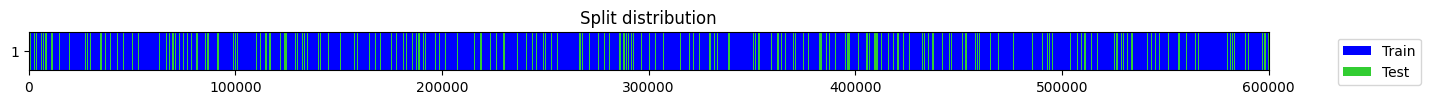

In [139]:
# Split to train set and test set
splits = get_splits(amounts, shuffle=True, valid_size=0.2)

## InceptionTime for Regression Task
This portion of code tries to train a tsai's InceptionTime model to predict the parameters matrix of the movements.

**Results:**
I've managed to receive an actual learning process only with the loss on the parameters, and not on the velocity reconstructed from.
And yet, the results are not good enough - You can run the 'show results' cell for demonstration.

In [123]:
# Create a TSDataset
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(velocities, parameters, tfms=tfms, splits=splits, inplace=True, verbose=True)

Setting up Pipeline: ToFloat


In [124]:
# Create a DadaLoaders

# Defining pipeline of filtering for the data - NOT WORKING for some reason...
# batch_tfms = [FilterTsfm()]

dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], num_workers=0)

In [ ]:
# Plot random bunch of samples
dls.show_batch(sharey=True)

In [130]:
# Defining the model, criterion and optimizer
model = InceptionTime(dls.vars, max_M * (2 + dim)).to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = get_loss_function("P")

In [148]:
# defining clip-layer to cut infeasible values from output parameters matrix
clip = ClipOutput(duration_min, amp_min)

In [149]:
# Training loop
def train_loop(q=50):
    num_epochs = 10
    for epoch in range(num_epochs):
        epoch_train_loss = 0.
        running_loss = 0.
        model.train()

        # Train
        for batch_idx, batch in enumerate(dls.train):
            inputs, targets = batch
            N = len(inputs)
            optimizer.zero_grad()
            predictions = model(inputs)

            # calculate M prediction accuracy
            real_counts = torch.count_nonzero(targets.view(N, -1, dim+2), dim=1)
            real_M = real_counts[:,0]
            pred_counts = torch.count_nonzero(clip(predictions).view(N, -1, dim+2), dim=1)
            pred_M = pred_counts[:,0]
            M_correctness = pred_M == real_M
            M_accuracy = torch.sum(M_correctness) / N

            # loss args: (vel, param, M, pred_vel, pred_param)
            loss = criterion(inputs, targets, real_M, batch_reconstruct_prof(predictions), predictions)
            epoch_train_loss += loss.item()
            running_loss += loss.item()

            # step
            loss.backward()
            optimizer.step()

            # print statistics
            if batch_idx % q == q-1:
                print(f'[{epoch + 1}, {batch_idx + 1:5d}] loss: {running_loss / q:.6f}. Accuracy: {M_accuracy}')
                running_loss = 0.

        # Evaluation
        model.eval()
        with torch.no_grad():
            avg_loss = 0.
            plot = True

            for batch in dls.valid:
                inputs, targets = batch
                N = len(inputs)
                predictions = model(inputs)

                real_counts = torch.count_nonzero(targets.view(N, -1, dim+2), dim=1)
                real_M = real_counts[:,0]
                pred_counts = torch.count_nonzero(clip(predictions).view(N, -1, dim+2), dim=1)
                pred_M = pred_counts[:,0]
                M_correctness = pred_M == real_M
                M_accuracy = torch.sum(M_correctness) / N

                loss = criterion(inputs, targets, real_M, batch_reconstruct_prof(predictions), predictions)
                avg_loss += loss.item()
                
                if plot:
                    # convert to minimum jerk curves
                    param_mat = predictions.view(N, -1, dim + 2)  # shape: (N, 7, 3) in case of 1-d
                    T = param_mat[:, :, 0]
                    D = param_mat[:, :, 1]
                    A = param_mat[:, :, 2:]
                    min_jerk_profiles = minimum_jerk_velocity(T.unsqueeze(-1), D.unsqueeze(-1), A, ts, True)  # shape: (N, 7, 1, 400) in case of 1-d           
                                        
                    fig, axs = plt.subplots(3,3)
                    for i in range(9):
                        ax = axs[i%3][i//3]
                        ax.plot(ts.cpu().detach().numpy(), inputs[i][0].cpu().detach().numpy(), 'red')
                        param, M = predictions[i].view(max_M, 2+dim), pred_M[i]
                        for min_j in min_jerk_profiles[i]:
                            ax.plot(ts.cpu().detach().numpy(), min_j[0].cpu().detach().numpy(), 'black', linestyle=':', linewidth=0.7)
                        ax.set_yticks([])
                        ax.set_xticks([])
                    fig.suptitle("Red = Real")
                    plt.show()
                    plot = False
                    
        print("****************** epoch done********* . loss: ", avg_loss / len(dls.valid), "M acc: ", M_accuracy.item() / len(dls.valid))
        epoch_train_loss = 0.
        torch.save(model.state_dict(), 'IncepTimeRegressor.pt')

In [ ]:
train_loop()

### show results

In [ ]:
# plot random reconstructed predictions
model.eval()
with torch.no_grad():
    inputs, targets = dls.valid.one_batch()
    N = len(inputs)
    predictions = clip(model(inputs))
    pred_vel = batch_reconstruct_prof(predictions)

    real_counts = torch.count_nonzero(targets.view(N, -1, dim+2), dim=1)
    real_M = real_counts[:,0]
    pred_counts = torch.count_nonzero(predictions.view(N, -1, dim+2), dim=1)
    pred_M = pred_counts[:,0]
    M_correctness = pred_M == real_M
    M_accuracy = torch.sum(M_correctness) / N

    for i in torch.randint(low=0, high=N, size=(16,)):
        plt.plot(ts.cpu().detach().numpy(), inputs[i][0].cpu().detach().numpy(), 'red')
        plt.plot(ts.cpu().detach().numpy(), pred_vel[i][0].cpu().detach().numpy(), 'black', linestyle=':', linewidth=0.7)
        plt.yticks([])
        plt.xticks([])
        fig.suptitle("Red = Real")
        plt.show()

In [ ]:
# Continue training with more epochs, this time include punishments in the loss
model = InceptionTime(dls.vars, max_M * (2 + dim)).to('cuda')
model.load_state_dict(torch.load('IncepTimeRegressor.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = get_loss_function("P+")

train_loop()

## InceptionTime for Classification Task
This portion of code tries to train a tsai's InceptionTime model to predict only the **amount** of sub movements in the sequence.

**Results:**
The model `models/M_Predictor/No_Filter_0.994_on_valid` was trained with no filtering on the inputs (for some reason it led to an error), and achieved total accuracy of **0.994** on the validation set.

### You first need to run those cells in order to run any other cell below

In [140]:
# Create a TSDataset
tfms  = [None, [TSClassification()]]
dsets = TSDatasets(velocities, amounts, tfms=tfms, splits=splits, inplace=True, verbose=True)

Setting up Pipeline: TSClassification -- {'vocab': None, 'sort': True}


In [141]:
# Create a DadaLoaders

# Defining pipeline of filtering for the data - NOT WORKING for some reason...
# batch_tfms = [FilterTsfm()]

dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], num_workers=0)

In [143]:
# defining the model
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)

### From here you can choose what cells to run as you wish

In [ ]:
# finding best lr
learn.lr_find()
# found lr = 0.0008317637839354575

In [ ]:
# train the model for 10 epochs
callback = SaveModel(monitor='accuracy', fname='BestModel', verbose=True)
learn.fit_one_cycle(10, lr_max=1e-5, cbs=callback)
learn.save('10_epochs')
learn.plot_metrics()
learn.save_all(path='export', dls_fname='dls', model_fname='M_predictor', learner_fname='inceptTime')

In [144]:
# loading the pre-trained model and check accuracy on the validation set
# Note that for every runtime there is a different valid-set, hence accuracy may vary a little bit
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.load('M_Predictor/No_Filter_0.994_on_valid')
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
print("Accuracy: ", (valid_targets == valid_preds).float().mean())

Accuracy:  tensor(0.9945)


### ? predictions == peaks ?
This code validate that the model can predict the amount ot movements contains different number of sub movements & peaks/troughs, and compare it to the success with the other samples.

**Conclusion:**
The model predicts in an equal way for both scenerios, pointing on the potential of the model finding a non-trivial decomposition of sub movements.

In [145]:
from scipy.signal import find_peaks

peaks_n_troughs = []
for batch in dls.valid:
    vel = batch[0]
    for v in vel:
        peaks, _ = find_peaks(v[0].cpu(), height=0)
        troughs, _ = find_peaks(-v[0].cpu(), height=0)
        peaks_n_troughs.append(len(peaks) + len(troughs))

peaks_n_troughs = torch.Tensor(peaks_n_troughs)

In [146]:
eq = torch.where(peaks_n_troughs == valid_targets)[0]
print("Percentages of samples where #peaks != M: ", eq.shape[0] / valid_targets.shape[0] * 100)
accuracy_on_eq = (valid_targets[eq] == valid_preds[eq]).float().mean()
print("Accuracy on those samples: ", accuracy_on_eq)

Percentages of samples where #peaks != M:  3.6358333333333333
Accuracy on those samples:  tensor(0.9574)


In [147]:
not_eq = torch.where(peaks_n_troughs != valid_targets)[0]
accuracy_on_not_eq = (valid_targets[not_eq] == valid_preds[not_eq]).float().mean()
print("Accuracy on all other samples: ", accuracy_on_not_eq)

Accuracy on all other samples:  tensor(0.9959)


# Conclusions from tsai's Model section:

1. Only `InceptionTime` was investigated here - I had no time to use different models...
2. The classification task accuracy achieved the goal: > 0.94. The model can be found at `models/M_Predictor/No_Filter_0.994_on_valid`.
3. I have validated the model with both validation set of the Big dataset, and the wntire Small dataset (which is unseen to the model). The results:
* **validation set:** Total success of ~99.4%. success of ~99.5% on the data where amount of peaks & troughs is equal to M, and ~95.5% on the other data.
* **Small dataset:** 99.43% of success, and it worth to note that this dataset have even **more** samples where the amount of peaks & troughs differ from M! (~12%). 
4. The regression task was more successful thatn My-Model section, but yet not enough. Further more, also here the loss function based on the velocity reconstruction was very week. You can see performances in the *show results* sub-section.

### TODO:
1. (1) & (2) from previous section's conclusions.
2. Create another data set, where the overlapping of the SMs is higher, and therefor the amount of peaks & troughs is more likle to differ from actual amount of sub movements. See conclusion number (3).
3. Get predictions of real-life, labeld data, and evaluate performance. Is the error rate of the model reflects profiles that their peaks-counting is different? (If Yes - this is a problem). What about trimmed-data from both sides?
4. Train different models. Have a look at the *New models* line in the main github page's readme file.
5. Try to train a BoF model using one of the tsai's model regressors.